# OUSD CHKS Exploration
This notebook explores data from the CHKS (California Healthy Kids Survey) in the OUSD (Oakland Unified School District) for the last year in the context of geographical gentrification data.

## Imports

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

## Clean up CHKS data
First step is to prepare the chks data.

In [2]:
# Load csv into dataframe
chks_df = pd.read_csv("../data/ousd_chks_raw.csv")
chks_df.head()

,Common Question Text (group),Common Question ID,Year ID,RowHeaderID,Network or School,Group By,Color Coding,Color Coding (group),Response Text,% of Total Count of Respondents,Count of Respondents,Show N's,% of Total Distinct count of Respondent ID
0,"During the past 12 months, about how many time...",174,2015-16,A20,Castlemont High School,All Students,661A,661A,0 times,47.619047619%,20,20,47.619047619%
1,"During the past 12 months, about how many time...",174,2015-16,A20,Castlemont High School,All Students,650B,650B,1–2 times,9.523809524%,4,4,9.523809524%
2,"During the past 12 months, about how many time...",174,2015-16,A20,Castlemont High School,All Students,640C,640C,A few times,28.571428571%,12,12,28.571428571%
3,"During the past 12 months, about how many time...",174,2015-16,A20,Castlemont High School,All Students,630D,630D,Once a month,2.380952381%,1,1,2.380952381%
4,"During the past 12 months, about how many time...",174,2015-16,A20,Castlemont High School,All Students,620E,620E,Once a week,2.380952381%,1,1,2.380952381%


In [3]:
# Delete unnecessary columns
del chks_df['Color Coding (group)']
del chks_df['Color Coding']
del chks_df['Group By']
del chks_df['RowHeaderID']
# Delete duplicate columns
print((chks_df['Count of Respondents'] != chks_df["Show N's"]).any())
del chks_df["Show N's"]
print((chks_df['% of Total Distinct count of Respondent ID'] 
       != chks_df["% of Total Count of Respondents"]).any())
del chks_df['% of Total Distinct count of Respondent ID']

False
False


In [4]:
# Rename columns to be easier to use
chks_df.rename(columns={
    'Network or School':'school_name',
    'Common Question Text (group)':'question_text',
    'Common Question ID':'question_id',
    'Year ID':'year_id',
    'Response Text':'response_text',
    'Count of Respondents':'num_responses',
    '% of Total Count of Respondents':'response_percentage'
}, inplace=True)

In [5]:
# Remove % from response_percentage
chks_df['response_percentage'] = chks_df['response_percentage'].str.replace('%', '').astype(np.float)

In [6]:
chks_df.head()

,question_text,question_id,year_id,school_name,response_text,response_percentage,num_responses
0,"During the past 12 months, about how many time...",174,2015-16,Castlemont High School,0 times,47.619048,20
1,"During the past 12 months, about how many time...",174,2015-16,Castlemont High School,1–2 times,9.523810,4
2,"During the past 12 months, about how many time...",174,2015-16,Castlemont High School,A few times,28.571429,12
3,"During the past 12 months, about how many time...",174,2015-16,Castlemont High School,Once a month,2.380952,1
4,"During the past 12 months, about how many time...",174,2015-16,Castlemont High School,Once a week,2.380952,1


## Merge chks data with location/gentrification data
This is a bit hacky: 
- Prep CHKS school names to not have tags (e.g. remove "high school" from name).
- Merge in columns of gentrification/location data by doing partial matches on school name

General hope is that the CHKS becomes a subset of the gentrification columns.

In [7]:
# Remove tags on end of school name
chks_df['school_name'] = chks_df['school_name'].str.lower()
school_name_tags = [" school", " hs"]
for tag in school_name_tags:
    chks_df['school_name'] = chks_df['school_name'].str.replace(tag, "")
    
    
# chks_df['school_name'] = chks_df['school_name'].apply(lambda name: re.escape(name))
chks_df.head()

,question_text,question_id,year_id,school_name,response_text,response_percentage,num_responses
0,"During the past 12 months, about how many time...",174,2015-16,castlemont high,0 times,47.619048,20
1,"During the past 12 months, about how many time...",174,2015-16,castlemont high,1–2 times,9.523810,4
2,"During the past 12 months, about how many time...",174,2015-16,castlemont high,A few times,28.571429,12
3,"During the past 12 months, about how many time...",174,2015-16,castlemont high,Once a month,2.380952,1
4,"During the past 12 months, about how many time...",174,2015-16,castlemont high,Once a week,2.380952,1


In [8]:
# Load in school gentrification data
# Using school_demand.gpkg because the names match our data better
school_gent_gdf = gpd.read_file('../data/school_demand.gpkg')
school_gent_gdf['school_name'] = school_gent_gdf['school_name'].str.lower()
school_gent_gdf.head()

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,school_name,demand_16_17,demand_17_18,demand_18_19,demand_19_20,demand_20_21,index_right,GEOID,Typology,geometry
0,westlake middle,73.4,56.8,67.1,52.6,49.0,570,6.001404e+09,Early/Ongoing Gentrification,POINT (-122.26000 37.81420)
1,west oakland middle,97.5,69.9,76.8,75.9,52.0,1910,6.001402e+09,At Risk of Gentrification,POINT (-122.28300 37.80900)
2,urban promise academy,92.9,80.0,104.0,124.6,92.8,334,6.001406e+09,At Risk of Gentrification,POINT (-122.22400 37.78210)
3,united for success academy,47.7,38.8,39.1,62.6,54.5,596,6.001406e+09,At Risk of Gentrification,POINT (-122.21900 37.78440)
4,life academy,242.2,216.7,238.7,191.7,189.6,596,6.001406e+09,At Risk of Gentrification,POINT (-122.21800 37.78600)


In [9]:
# How many schools do we have without matches???
no_match = set()
for name in chks_df['school_name']:
    df = school_gent_gdf[school_gent_gdf['school_name'].str.contains(name)]
    if len(df.index) == 0:
        no_match.add(name)
        
print(len(no_match))
print(no_match)

/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


7
{'community day', 'rudsdale continuation', 'gateway to college', 'ralph j bunche high', 'rudsdale (newcomer)', 'dewey academy', 'sojourner truth independent study'}


#### This is about to get real ugly...

In [10]:
chks_df = chks_df[chks_df['school_name'].apply(
    lambda name: school_gent_gdf['school_name'].str.contains(name, regex=False).any()
)]

In [11]:
chks_df['gentrification_typology'] = chks_df['school_name'].apply(
    lambda name: school_gent_gdf[school_gent_gdf['school_name'].str.contains(name, regex=False)]['Typology'].item()
)
chks_df['gentrification_typology']

0       Low-Income/Susceptible to Displacement
1       Low-Income/Susceptible to Displacement
2       Low-Income/Susceptible to Displacement
3       Low-Income/Susceptible to Displacement
4       Low-Income/Susceptible to Displacement
                         ...                  
2882                 At Risk of Gentrification
2883                 At Risk of Gentrification
2884                 At Risk of Gentrification
2885                 At Risk of Gentrification
2886                 At Risk of Gentrification
Name: gentrification_typology, Length: 1949, dtype: object

In [12]:
chks_df['geometry'] = chks_df['school_name'].apply(
    lambda name: school_gent_gdf[school_gent_gdf['school_name'].str.contains(name, regex=False)]['geometry'].item()
)
chks_df['geometry']

0       POINT (-122.164 37.7599)
1       POINT (-122.164 37.7599)
2       POINT (-122.164 37.7599)
3       POINT (-122.164 37.7599)
4       POINT (-122.164 37.7599)
                  ...           
2882    POINT (-122.265 37.8178)
2883    POINT (-122.265 37.8178)
2884    POINT (-122.265 37.8178)
2885    POINT (-122.265 37.8178)
2886    POINT (-122.265 37.8178)
Name: geometry, Length: 1949, dtype: object

## Explore trends in data
Are there any interesting trends? What do things look like?

### Let's get some groups

In [13]:
# Extract question 13: I feel like I am part of this school.
belonging_df = chks_df.groupby('question_id').get_group(13)
belonging_df.head()

,question_text,question_id,year_id,school_name,response_text,response_percentage,num_responses,gentrification_typology,geometry
2138,I feel like I am part of this school.,13,2015-16,castlemont high,Strongly Agree,16.666667,7,Low-Income/Susceptible to Displacement,POINT (-122.164 37.7599)
2139,I feel like I am part of this school.,13,2015-16,castlemont high,Agree,30.952381,13,Low-Income/Susceptible to Displacement,POINT (-122.164 37.7599)
2140,I feel like I am part of this school.,13,2015-16,castlemont high,Neither Disagree Nor Agree,40.476190,17,Low-Income/Susceptible to Displacement,POINT (-122.164 37.7599)
2141,I feel like I am part of this school.,13,2015-16,castlemont high,Disagree,4.761905,2,Low-Income/Susceptible to Displacement,POINT (-122.164 37.7599)
2142,I feel like I am part of this school.,13,2015-16,castlemont high,Strongly Disagree,4.761905,2,Low-Income/Susceptible to Displacement,POINT (-122.164 37.7599)


### Filter only responses that either strongly agree or agree

In [14]:
belonging_agree = belonging_df[
    (belonging_df['response_text'] == 'Strongly Agree') 
    | (belonging_df['response_text'] == 'Agree')
]
belonging_agree.head()

,question_text,question_id,year_id,school_name,response_text,response_percentage,num_responses,gentrification_typology,geometry
2138,I feel like I am part of this school.,13,2015-16,castlemont high,Strongly Agree,16.666667,7,Low-Income/Susceptible to Displacement,POINT (-122.164 37.7599)
2139,I feel like I am part of this school.,13,2015-16,castlemont high,Agree,30.952381,13,Low-Income/Susceptible to Displacement,POINT (-122.164 37.7599)
2144,I feel like I am part of this school.,13,2015-16,coliseum college prep academy,Strongly Agree,10.961969,49,Low-Income/Susceptible to Displacement,POINT (-122.194 37.7614)
2145,I feel like I am part of this school.,13,2015-16,coliseum college prep academy,Agree,38.702461,173,Low-Income/Susceptible to Displacement,POINT (-122.194 37.7614)
2162,I feel like I am part of this school.,13,2015-16,fremont high,Strongly Agree,8.893709,41,Ongoing Displacement,POINT (-122.209 37.7736)


### Group by year first, then school
This way we can plot for each year what the percent agreement was

In [15]:
belonging_schools_agree = belonging_agree.groupby(['year_id', 'school_name'])

In [16]:
belong_agreement = belonging_schools_agree.agg({
    'response_percentage':'sum',
    'gentrification_typology':'first',
    'geometry':'first'
})

### For each year, plot the percent agreement in the context of the gentrification map

In [17]:
gent_gdf = gpd.read_file('../data/sanfrancisco.gpkg')

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [18]:
min_agree = belong_agreement['response_percentage'].min()
max_agree = belong_agreement['response_percentage'].max()

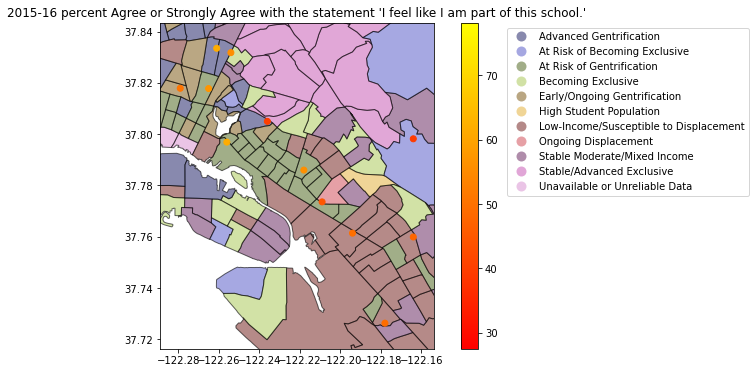

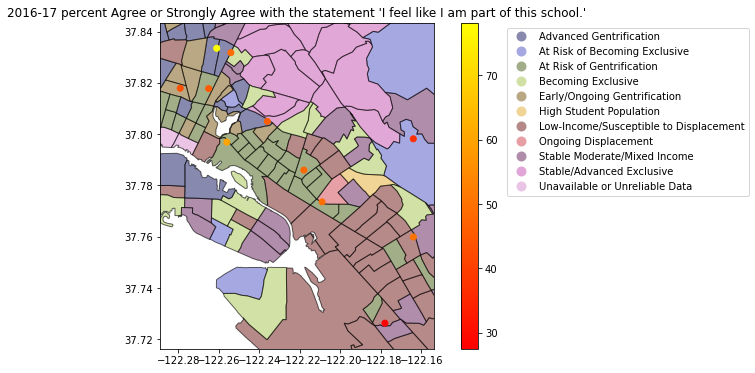

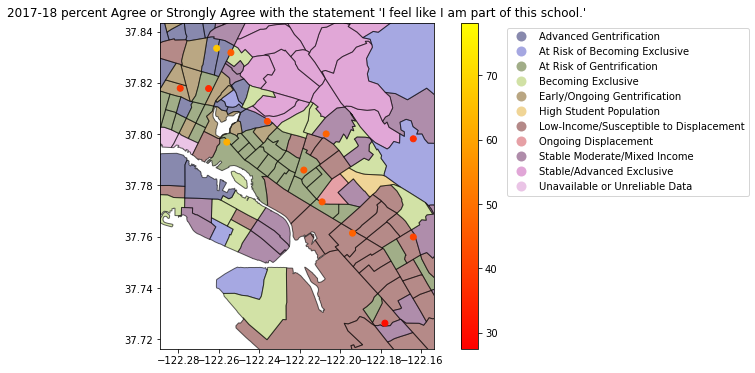

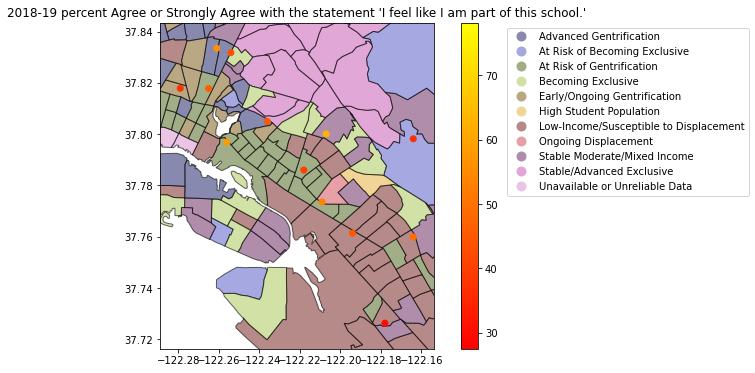

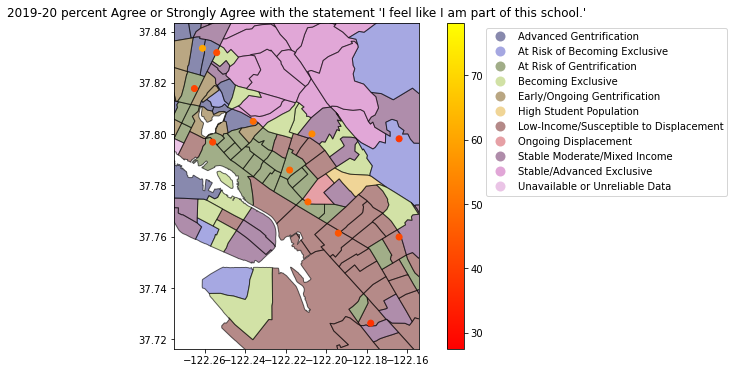

In [19]:
for year, df in belong_agreement.groupby(level=0):
    #gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326').plot(column='gentrification_typology', s=df['response_percentage'], legend=True)
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
    f, ax = plt.subplots(figsize=(10,6))
    gent_gdf.plot(
        column='Typology',
        cmap='tab20b',
        edgecolor='black',
        alpha=.6,
        legend=True,
        legend_kwds=dict(bbox_to_anchor=(1.25, 1)),
        ax=ax
    )
    gdf.plot(
        column='response_percentage',
        cmap='autumn',
        legend=True,
        vmin=min_agree,
        vmax=max_agree,
        ax=ax
    )
    buffer = 0.01
    ax.set_xlim(gdf.total_bounds[0] - buffer, gdf.total_bounds[2] + buffer)
    ax.set_ylim(gdf.total_bounds[1] - buffer, gdf.total_bounds[3] + buffer)
    ax.set_title("{} percent Agree or Strongly Agree with the statement 'I feel like I am part of this school.'".format(year))

### Now plot change from first to last year of the survey
This means we will have to group by school then year, then we can calculate a difference from the first to last year for each school

Text(0.5, 1.0, "Change in percent agree or strongly agree with 'I feel like I am part of this school.' from first to last year")

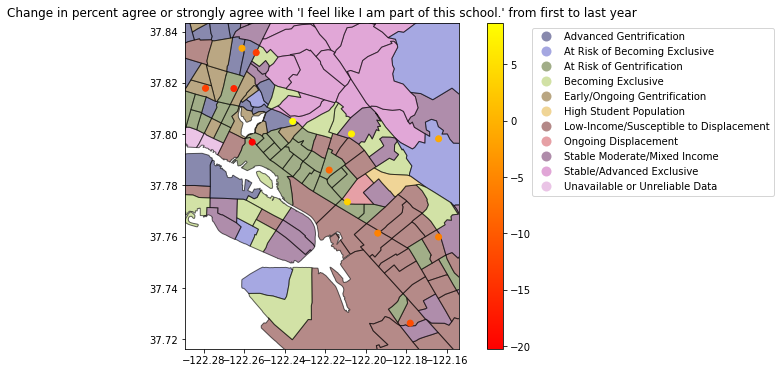

In [20]:
agree_by_school = belonging_agree.groupby(['school_name', 'year_id']).agg({'response_percentage':'sum', 'gentrification_typology':'first', 'geometry':'first'})
merged_first_last = pd.merge(
    agree_by_school.reset_index().groupby('school_name', as_index=False).first(), 
    agree_by_school.reset_index().groupby('school_name', as_index=False).last(),
    on='school_name'
)
merged_first_last['response_difference'] = merged_first_last['response_percentage_y'] - merged_first_last['response_percentage_x']
merged_first_last_gdf = gpd.GeoDataFrame(merged_first_last, geometry='geometry_x', crs='EPSG:4326')
f, ax = plt.subplots(figsize=(10,6))
gent_gdf.plot(
    column='Typology',
    cmap='tab20b',
    edgecolor='black',
    alpha=.6,
    legend=True,
    legend_kwds=dict(bbox_to_anchor=(1.25, 1)),
    ax=ax
)
merged_first_last_gdf.plot(
    column='response_difference',
    cmap='autumn',
    legend=True,
    ax=ax
)
buffer = 0.01
ax.set_xlim(merged_first_last_gdf.total_bounds[0] - buffer, merged_first_last_gdf.total_bounds[2] + buffer)
ax.set_ylim(merged_first_last_gdf.total_bounds[1] - buffer, merged_first_last_gdf.total_bounds[3] + buffer)
ax.set_title("Change in percent agree or strongly agree with 'I feel like I am part of this school.' from first to last year")

Could further explore trends in data and other questions using groupby, but not enough time right now for me to do so :(